# Adding and Rotating Molecules in Crystals

This notebook demonstrates how to use the `add_structure_at_position`, `rotate_structure_around_point` and `rotate_structure_around_vector` functions to add a molecule at a certain position and rotates it around a certain point. Additionally, a whole sub structure will be rotated around a given vector.

- **UniforStrainng**: Appliestrainor uniformly across all lattice directionsn.
- **Anisotropic Strain**: Applies strain along each lattice axis individually.
- **Strain and Shear Transformations**: Utilizes a strain tensor to apply anisotrotrain and shear.

### Loading Framework and Molecule

- Load the framework "PBI3" from `PBI3.xyz` via `from_file` with the `Structure` class.
- Load the molecule "CN2H5" from `CN2H5.xyz` via `from_file` with the `Structure` class.


In [1]:
from aim2dat.strct import Structure

framework = Structure.from_file("files/strc/PBI3.xyz")
molecule = Structure.from_file("files/strc/CN2H5.xyz")

### Example 1: Adding a Molecule into the Framework

In this case, we demonstrate to add a molecule at a certain position. The center of the framework was chosen.


In [2]:
from aim2dat.strct.ext_manipulation import add_structure_at_position

structure = add_structure_at_position(framework, [3.176186, 3.244215, 3.25149 ], molecule)

This molecule is now included into the framework shown down below:

<Axes: >

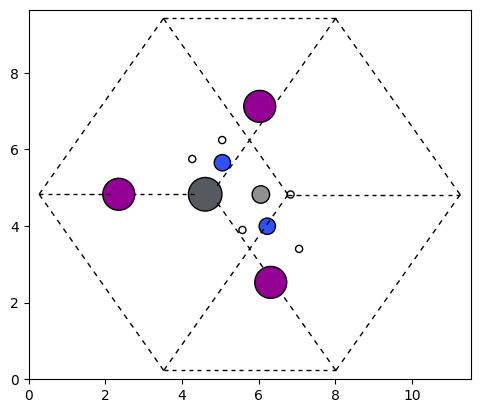

In [3]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

fig, ax = plt.subplots()
plot_atoms(structure.to_ase_atoms(), ax, radii=0.3, rotation=('45x,45y,0z'))

### Example 2: Rotate a Molecule in a structure

In this case, we demonstrate to rotate the new added molecule around its center with 90 degrees in the x-axis. For this we need to know the side indices of the structure.


In [4]:
from aim2dat.strct.ext_manipulation import rotate_structure_around_point

rot_strct = rotate_structure_around_point(structure, [4, 5, 6, 7, 8, 9, 10, 11], [90,0,0])

This molecule is now rotated in the framework shown down below:

<Axes: >

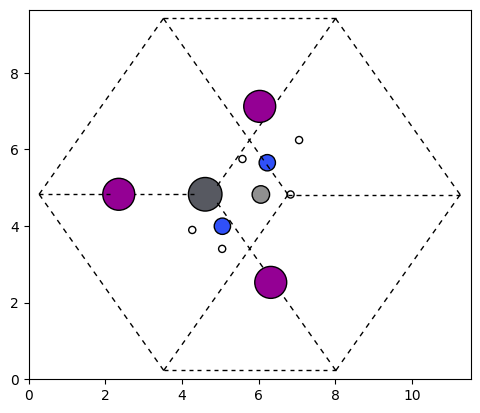

In [5]:
fig, ax = plt.subplots()
plot_atoms(rot_strct.to_ase_atoms(), ax, radii=0.3, rotation=('45x,45y,0z'))

### Example 3: Rotate a sub structure of a crystal

In this case, we demonstrate to rotate each linker molecule in the MOF-5 by 90 degrees around the rotation vector connecting the furthest carbon atoms. First, we need to load the new structure.


In [6]:
MOF5 = Structure.from_file("files/strc/MOF5_prim.xsf")

Now we can find each fragment of the structure by setting the start and end point to "Zn" and excluding not needed elements "Zn" and "O".

In [ ]:
from aim2dat.strct.ext_analysis import determine_molecular_fragments

fragments = determine_molecular_fragments(
    MOF5,
    exclude_elements=["Zn", "O"],
    end_point_elements = "Zn", 
    cn_method="econ",
    econ_tolerance = 0.05,
    econ_conv_threshold = 0.001, 
)

With this information, we will find each connection pair and their connecting vector

In [ ]:
import numpy as np
pairs = []
rotation_vectors = []
for frag in fragments:
    max_dist = 0
    for idx1, pos1 in zip(frag["site_indices"], frag["positions"]):
        for idx2, pos2 in zip(frag["site_indices"], frag["positions"]):
            if idx1 == idx2:
                continue
            dist = np.linalg.norm(np.array(pos1)-np.array(pos2))
            if dist > max_dist:
                paar = (idx1, idx2)
                rot_vec = np.array(pos1)-np.array(pos2)
                max_dist = dist
    pairs.append(paar)
    rotation_vectors.append(rot_vec)

Now we can iterate through all fragments and rotate them by 90 degrees. For this, we copy the original structure, so it will not be manipulated. In this case, we do not change the label, since each iteration would change each time.

In [ ]:
from copy import deepcopy
from aim2dat.strct.ext_manipulation import rotate_structure_around_vector

rot_strct = deepcopy(MOF5)
for pair, frag, rot_vec in zip(pairs, fragments, rotation_vectors):
    rot_strct = rotate_structure_around_vector(
        rot_strct,
        site_indices = frag["site_indices"],
        angle = 90,
        rotation_vector = rot_vec,
        origin = MOF5.get_positions()[pair[0]],
        change_label = False,
        wrap = True,
    )

Now we can compare before and after.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)
plot_atoms(MOF5.to_ase_atoms(), ax[0], radii=0.3, rotation=('45x,45y,0z'))
plot_atoms(rot_strct.to_ase_atoms(), ax[1], radii=0.3, rotation=('45x,45y,0z'))